# Memprediksi Pasar Saham dengan metode Markov

Saya menemukan sebuah project milik <a href="https://pkghosh.wordpress.com/2015/07/06/customer-conversion-prediction-with-markov-chain-classifier/">Mawazo</a>, didalam websitenya(https://pkghosh.wordpress.com/2015/07/06/customer-conversion-prediction-with-markov-chain-classifier/) ia membahas bagaimana kita dapat mengimplementasikan markov chain untuk memprediksi sequence data. Dalam projectnya ia menggunakannya untuk "Customer Conversion Prediction" dari situ saya berpikir bahwa metode yang telah digunakannya dapat digunakan juga untuk project saya yaitu memprediksi pasar saham. Disini saya menggunakan 3 dataset yaitu ASRI, LPKR, dan BSDE yang dapat di unduh melalui link berikut :
1. <a href="https://finance.yahoo.com/quote/ASRI.JK/">ASRI</a> 
2. <a href="https://finance.yahoo.com/quote/LPKR.JK/">LPKR</a> 
3. <a href="https://finance.yahoo.com/quote/bsde.jk/">BSDE</a>

<a href="https://ibb.co/3pknqzb"><img src="https://i.ibb.co/Byw9xNJ/infografis.png" alt="infografis" border="0"></a>

## Markov Chain

Menurut website <a href="https://brilliant.org/wiki/markov-chains/">brilliant</a>  "A Markov chain is a mathematical system that experiences transitions from one state to another according to certain probabilistic rules."

Markov chain dapat dimodelkan dengan menggunakan <a href="https://brilliant.org/wiki/finite-state-machines/">finite state machine</a> 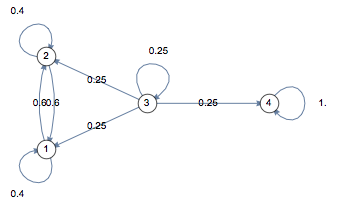

## First-Order Markov Transition Matrix 

Merupakan dasar dari markovian chain. First order adalah turunan pertama dari prediksi atau langkah pertama dalam menentukan next outcome yang akan muncul.

## Membuat Pattern khusus agar dapat menggunakan metode Markov

Dalam bentuk mentahnya, data indeks hanya mewakili satu urutan dari banyak peristiwa yang mengarah ke harga kuotasi terakhir. Untuk mendapatkan lebih banyak urutan dan, yang lebih penting, mendapatkan pemahaman yang lebih baik tentang perilaku pasar, kita perlu memecah data menjadi banyak sampel yang mengarah ke pola harga yang berbeda. Dengan cara ini kita dapat membangun pattern perilaku pasar yang cukup kaya dan berupaya mencocokkannya dengan pola masa depan untuk memprediksi hasil di masa depan. Misalnya, di bawah ini adalah dua set penutupan harga berturut-turut. Mereka mewakili periode yang berbeda dan mengandung jumlah harga yang bervariasi. Agar dapat lebih jelas maka dapat dilihat pada contoh dibawah ini :

**2019-01-01 to 2019-11-21**

352.000 –> 346.000 –> 344.000 –> Next Day Volume Up

**2019-08-01 to 2019-11-22**

334.000 –> 348.000 –> 352.000 –> 320.000 –> 311.00 –> Next Day Volume Down

Dari sini akan dibandingkan pembukaan hari versus penutupan hari, tinggi hari sebelumnya ke tinggi saat ini, rendah hari sebelumnya ke rendah saat ini, volume hari sebelumnya dengan yang sekarang, dll.

## Membuat First order dengan Grup yang berisi 3 Buckets

Menyederhanakan setiap peristiwa dalam urutan menjadi satu fitur. Dia membagi nilainya menjadi 3 kelompok - Low(L), Medium(M), High(H). Contoh :

**-0.00061292029** | **-0.00296180545**|**0.00276237955**| **0.00224404520**|**0.00550964565**|**0.00513322970**
------------ | -------------|------------|------------|------------|------------
**"M"** | **"L"** |**"M"**| **"M"** |**"H"** |**"H"**



Dari buckets tersebut dapat dilakukan second order sampai n+1 -order dengan menggabungkan masing - masing buckets. Sebagai contoh **"MHLL"** 


dari gabungan tersebut maka kita dapat membuat sebuah string menjadi :

**"HMML" "MHHL" "LLMH" "HLMM" "HHHL" "HHHH" --> Volume Up**

## Membuat 2 Markov chain

Markov chain pertama untuk Volume Jump dan lainnya untuk Volume Drop

# Prediksi Market ASRI

In [536]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import io, base64, os, json, re 
import pandas as pd
import numpy as np
import datetime
from random import randint

In [537]:
asri_df = pd.read_csv("C:\proyek_prob\ASRI.JK.csv")
asri_df['Date'] = pd.to_datetime(asri_df['Date'])

cut_off_date = '2019-01-01' 
asri_df = asri_df[asri_df['Date'] >= cut_off_date]


asri_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
18,2019-01-01,312.0,312.0,312.0,312.0,312.0,0.0
19,2019-01-02,312.0,318.0,308.0,310.0,310.0,5356300.0
20,2019-01-03,314.0,330.0,310.0,330.0,330.0,17812200.0
21,2019-01-04,330.0,334.0,326.0,328.0,328.0,15591200.0
22,2019-01-07,334.0,342.0,330.0,334.0,334.0,12399800.0


In [538]:
new_set = []
for row_set in range(0, 10000):
    if row_set%2000==0: print(row_set)
    row_quant = randint(10, 30)
    row_start = randint(0, len(asri_df)-row_quant)
    market_subset = asri_df.iloc[row_start:row_start+row_quant]

    Close_Date = max(market_subset['Date'])
    if row_set%2000==0: print(Close_Date)
    
    # Close_Gap = (market_subset['Close'] - market_subset['Close'].shift(1)) / market_subset['Close'].shift(1)
    Close_Gap = market_subset['Close'].pct_change()
    High_Gap = market_subset['High'].pct_change()
    Low_Gap = market_subset['Low'].pct_change() 
    Volume_Gap = market_subset['Volume'].pct_change() 
    Daily_Change = (market_subset['Close'] - market_subset['Open']) / market_subset['Open']
    Outcome_Next_Day_Direction = (market_subset['Volume'].shift(-1) - market_subset['Volume'])
    
    new_set.append(pd.DataFrame({'Sequence_ID':[row_set]*len(market_subset),
                            'Close_Date':[Close_Date]*len(market_subset),
                           'Close_Gap':Close_Gap,
                           'High_Gap':High_Gap,
                           'Low_Gap':Low_Gap,
                           'Volume_Gap':Volume_Gap,
                           'Daily_Change':Daily_Change,
                           'Outcome_Next_Day_Direction':Outcome_Next_Day_Direction}))

0
2019-09-13 00:00:00
2000
2019-08-12 00:00:00
4000
2019-02-19 00:00:00
6000
2019-02-25 00:00:00
8000
2019-06-11 00:00:00


In [539]:
len(market_subset)

14

In [540]:
new_set_df = pd.concat(new_set)
print(new_set_df.shape)
new_set_df = new_set_df.dropna(how='any') 
print(new_set_df.shape)
new_set_df.tail(20)

(199189, 8)
(173294, 8)


,Sequence_ID,Close_Date,Close_Gap,High_Gap,Low_Gap,Volume_Gap,Daily_Change,Outcome_Next_Day_Direction
50,9998,2019-02-26,-0.005814,0.005780,0.000000,1.238501,-0.011561,-276600.0
51,9998,2019-02-26,-0.035088,-0.011494,-0.029412,-0.023495,-0.040698,-4656500.0
52,9998,2019-02-26,0.018182,-0.023256,0.000000,-0.405057,0.018182,-1477500.0
53,9998,2019-02-26,-0.011905,0.011905,0.006061,-0.216028,-0.017751,11262000.0
54,9998,2019-02-26,-0.006024,-0.005882,-0.018072,2.100375,-0.006024,17427800.0
55,9998,2019-02-26,0.000000,-0.011834,0.000000,1.048358,-0.006024,-20045900.0
56,9998,2019-02-26,-0.006061,-0.005988,-0.006135,-0.588690,-0.012048,-532100.0
57,9998,2019-02-26,-0.006098,0.006024,0.006173,-0.037991,-0.012121,1401300.0
134,9999,2019-06-28,0.000000,0.000000,0.006173,0.095897,-0.006061,11971200.0
135,9999,2019-06-28,0.024390,0.018072,-0.030675,2.152784,0.024390,-11149500.0


In [541]:
new_set_df.head()

,Sequence_ID,Close_Date,Close_Gap,High_Gap,Low_Gap,Volume_Gap,Daily_Change,Outcome_Next_Day_Direction
187,0,2019-09-13,-0.006369,-0.012500,-0.019108,0.432919,-0.012658,2304200.0
188,0,2019-09-13,-0.019231,-0.012658,-0.006494,0.533083,-0.019231,-3745600.0
189,0,2019-09-13,0.019608,0.006410,0.000000,-0.565237,0.019608,2080700.0
190,0,2019-09-13,-0.012821,0.000000,0.000000,0.722215,-0.019108,-1592000.0
191,0,2019-09-13,0.012987,0.000000,0.006536,-0.320858,0.012987,2691600.0


In [542]:
# Close Gap
new_set_df['Close_Gap_LMH'] = pd.qcut(new_set_df['Close_Gap'], 3, labels=["L", "M", "H"])

# High Gap
new_set_df['High_Gap_LMH'] = pd.qcut(new_set_df['High_Gap'], 3, labels=["L", "M", "H"])

# Low Gap
new_set_df['Low_Gap_LMH'] = pd.qcut(new_set_df['Low_Gap'], 3, labels=["L", "M", "H"])

# Volume Gap
new_set_df['Volume_Gap_LMH'] = pd.qcut(new_set_df['Volume_Gap'], 3, labels=["L", "M", "H"])
 
# Daily Change
new_set_df['Daily_Change_LMH'] = pd.qcut(new_set_df['Daily_Change'], 3, labels=["L", "M", "H"])

# new set
new_set_df = new_set_df[["Sequence_ID", 
                         "Close_Date", 
                         "Close_Gap_LMH", 
                         "Volume_Gap_LMH", 
                         "Daily_Change_LMH", 
                         "Outcome_Next_Day_Direction"]]

new_set_df['Event_Pattern'] = new_set_df['Close_Gap_LMH'].astype(str) + new_set_df['Volume_Gap_LMH'].astype(str) + new_set_df['Daily_Change_LMH'].astype(str)

In [543]:
new_set_df.tail(10)

,Sequence_ID,Close_Date,Close_Gap_LMH,Volume_Gap_LMH,Daily_Change_LMH,Outcome_Next_Day_Direction,Event_Pattern
136,9999,2019-06-28,L,L,L,-3344500.0,LLL
137,9999,2019-06-28,L,L,L,2629600.0,LLL
138,9999,2019-06-28,H,H,H,15347800.0,HHH
139,9999,2019-06-28,H,H,H,1479200.0,HHH
140,9999,2019-06-28,L,M,L,-17310900.0,LML
141,9999,2019-06-28,M,L,M,6072200.0,MLM
142,9999,2019-06-28,H,H,H,5061900.0,HHH
143,9999,2019-06-28,H,H,H,-10849700.0,HHH
144,9999,2019-06-28,M,L,M,-1721500.0,MLM
145,9999,2019-06-28,M,L,M,-633300.0,MLM


In [544]:
new_set_df['Outcome_Next_Day_Direction'].describe()

count    1.732940e+05
mean    -6.679625e+04
std      8.808616e+06
min     -4.251000e+07
25%     -3.839600e+06
50%      1.997000e+05
75%      3.168100e+06
max      4.333470e+07
Name: Outcome_Next_Day_Direction, dtype: float64

In [545]:
compressed_set = new_set_df.groupby(['Sequence_ID','Close_Date'])['Event_Pattern'].apply(lambda x: "{%s}" % ', '.join(x)).reset_index()

print(compressed_set.shape)
compressed_set.head() 

(10000, 3)


,Sequence_ID,Close_Date,Event_Pattern
0,0,2019-09-13,"{MHL, LHL, HLH, LHL, HLH, LHM, MLM, LHL, HMM, ..."
1,1,2019-10-01,"{LHM, HMH, LML, HHH, LLL, LML, MLL, LMM, HMH, ..."
2,2,2019-04-11,"{LHL, HHH, HMH, MLM, HHH, HLL, HMH, HHH, LLL}"
3,3,2019-08-19,"{HHH, HHH, LLL, MHH, MLL, MHM, HHH, LLL, MHM, ..."
4,4,2019-01-30,"{HHH, MMM, HMM, MMM, HHH, HMM, MLH, LLL, HHH, ..."


In [546]:
compressed_outcomes = new_set_df.groupby(['Sequence_ID', 'Close_Date'])['Outcome_Next_Day_Direction'].mean()
compressed_outcomes = compressed_outcomes.to_frame().reset_index()
print(compressed_outcomes.shape)
compressed_outcomes.describe()

(10000, 3)


,Sequence_ID,Outcome_Next_Day_Direction
count,10000.00000,1.000000e+04
mean,4999.50000,-6.929010e+04
std,2886.89568,7.082833e+05
min,0.00000,-7.264825e+06
25%,2499.75000,-3.463250e+05
50%,4999.50000,-2.010357e+04
75%,7499.25000,2.092817e+05
max,9999.00000,7.009862e+06


In [547]:
compressed_set = pd.merge(compressed_set, compressed_outcomes, on= ['Sequence_ID', 'Close_Date'], how='inner')
print(compressed_set.shape)
compressed_set.head()

(10000, 4)


,Sequence_ID,Close_Date,Event_Pattern,Outcome_Next_Day_Direction
0,0,2019-09-13,"{MHL, LHL, HLH, LHL, HLH, LHM, MLM, LHL, HMM, ...",54842.857143
1,1,2019-10-01,"{LHM, HMH, LML, HHH, LLL, LML, MLL, LMM, HMH, ...",-189194.117647
2,2,2019-04-11,"{LHL, HHH, HMH, MLM, HHH, HLL, HMH, HHH, LLL}",547744.444444
3,3,2019-08-19,"{HHH, HHH, LLL, MHH, MLL, MHM, HHH, LLL, MHM, ...",-108674.074074
4,4,2019-01-30,"{HHH, MMM, HMM, MMM, HHH, HMM, MLH, LLL, HHH, ...",29373.684211


In [548]:
compressed_set['Event_Pattern'] = [''.join(e.split()).replace('{','').replace('}','') for e in compressed_set['Event_Pattern'].values]
compressed_set.head()

,Sequence_ID,Close_Date,Event_Pattern,Outcome_Next_Day_Direction
0,0,2019-09-13,"MHL,LHL,HLH,LHL,HLH,LHM,MLM,LHL,HMM,LHM,HMH,LM...",54842.857143
1,1,2019-10-01,"LHM,HMH,LML,HHH,LLL,LML,MLL,LMM,HMH,MML,LML,HM...",-189194.117647
2,2,2019-04-11,"LHL,HHH,HMH,MLM,HHH,HLL,HMH,HHH,LLL",547744.444444
3,3,2019-08-19,"HHH,HHH,LLL,MHH,MLL,MHM,HHH,LLL,MHM,MLM,MMM,MH...",-108674.074074
4,4,2019-01-30,"HHH,MMM,HMM,MMM,HHH,HMM,MLH,LLL,HHH,HLM,LLL,LL...",29373.684211


In [549]:
compressed_set_validation = compressed_set[compressed_set['Close_Date'] >= datetime.datetime.now() - datetime.timedelta(days=90)] # Sys.Date()-90 

compressed_set_validation.shape

(2534, 4)

In [550]:
compressed_set = compressed_set[compressed_set['Close_Date'] < datetime.datetime.now() - datetime.timedelta(days=90)]  
compressed_set.shape

(7466, 4)

In [551]:
list(compressed_set)

['Sequence_ID', 'Close_Date', 'Event_Pattern', 'Outcome_Next_Day_Direction']

In [552]:
compressed_set = compressed_set[['Sequence_ID', 'Event_Pattern','Outcome_Next_Day_Direction']]
compressed_set_validation = compressed_set_validation[['Sequence_ID', 'Event_Pattern','Outcome_Next_Day_Direction']]

In [553]:
compressed_set['Outcome_Next_Day_Direction'].describe()

count    7.466000e+03
mean    -1.062478e+05
std      7.981125e+05
min     -7.264825e+06
25%     -4.391792e+05
50%     -5.869156e+04
75%      2.236400e+05
max      7.009862e+06
Name: Outcome_Next_Day_Direction, dtype: float64

In [554]:
print(len(compressed_set['Outcome_Next_Day_Direction']))
len(compressed_set[abs(compressed_set['Outcome_Next_Day_Direction']) > 100000])

7466


6195

In [555]:
# keep only keep big/interesting moves 
print('all moves:', len(compressed_set))
compressed_set = compressed_set[abs(compressed_set['Outcome_Next_Day_Direction']) > 100000]
compressed_set['Outcome_Next_Day_Direction'] = np.where((compressed_set['Outcome_Next_Day_Direction'] > 0), 1, 0)
compressed_set_validation['Outcome_Next_Day_Direction'] = np.where((compressed_set_validation['Outcome_Next_Day_Direction'] > 0), 1, 0)
print('big moves only:', len(compressed_set)) 

all moves: 7466
big moves only: 6195


In [556]:
compressed_set.head()

,Sequence_ID,Event_Pattern,Outcome_Next_Day_Direction
2,2,"LHL,HHH,HMH,MLM,HHH,HLL,HMH,HHH,LLL",1
3,3,"HHH,HHH,LLL,MHH,MLL,MHM,HHH,LLL,MHM,MLM,MMM,MH...",0
5,5,"MLM,MMM,MLM,HHH,LHL,LLL,HMH,LMM,LHL,MLM,LHL,HL...",0
7,7,"LLL,HHH,HMH,MLM,HLH,HHH,LHL,HLH,MLM,HHH,MLM",0
9,9,"LLL,HMH,LMM,LHL,MLM,LHL,HLH,LLL,LML,LHL,LLL,HH...",0


In [557]:
# create two data sets - won/not won
compressed_set_pos = compressed_set[compressed_set['Outcome_Next_Day_Direction']==1][['Sequence_ID', 'Event_Pattern']]
print(compressed_set_pos.shape)
compressed_set_neg = compressed_set[compressed_set['Outcome_Next_Day_Direction']==0][['Sequence_ID', 'Event_Pattern']]
print(compressed_set_neg.shape)

(2664, 2)
(3531, 2)


In [558]:
flat_list = [item.split(',') for item in compressed_set['Event_Pattern'].values ]
unique_patterns = ','.join(str(r) for v in flat_list for r in v)
unique_patterns = list(set(unique_patterns.split(',')))
len(unique_patterns)

22

In [559]:
compressed_set['Outcome_Next_Day_Direction'].head() 

2    1
3    0
5    0
7    0
9    0
Name: Outcome_Next_Day_Direction, dtype: int32

## The markov transition grid

In [560]:
# build the markov transition grid
def build_transition_grid(compressed_grid, unique_patterns):
    # build the markov transition grid

    patterns = []
    counts = []
    for from_event in unique_patterns:

        # how many times 
        for to_event in unique_patterns:
            pattern = from_event + ',' + to_event # MMM,MlM

            ids_matches = compressed_grid[compressed_grid['Event_Pattern'].str.contains(pattern)]
            found = 0
            if len(ids_matches) > 0:
                Event_Pattern = '---'.join(ids_matches['Event_Pattern'].values)
                found = Event_Pattern.count(pattern)
            patterns.append(pattern)
            counts.append(found)

    # create to/from grid
    grid_Df = pd.DataFrame({'pairs':patterns, 'counts': counts})

    grid_Df['x'], grid_Df['y'] = grid_Df['pairs'].str.split(',', 1).str
    grid_Df.head()

    grid_Df = grid_Df.pivot(index='x', columns='y', values='counts')

    grid_Df.columns= [col for col in grid_Df.columns]
    del grid_Df.index.name

    # replace all NaN with zeros
    grid_Df.fillna(0, inplace=True)
    grid_Df.head()

    #grid_Df.rowSums(transition_dataframe) 
    grid_Df = grid_Df / grid_Df.sum(1)
    return (grid_Df)

In [561]:
grid_pos = build_transition_grid(compressed_set_pos, unique_patterns) 
grid_neg = build_transition_grid(compressed_set_neg, unique_patterns) 

In [562]:
grid_neg.head()

,HHH,HHM,HLH,HLL,HLM,HMH,HMM,LHL,LHM,LLL,...,LML,LMM,MHH,MHL,MHM,MLH,MLL,MLM,MMH,MMM
HHH,0.147358,0.0,0.0,0.944,0.554884,0.320412,0.462264,0.190199,0.000000,0.289092,...,0.099371,0.0,0.0,0.0,0.000000,0.0,0.0,0.210637,0.541391,0.008459
HHM,0.000000,0.0,0.0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.083401,0.0,0.0,0.000000,0.000000,0.000000
HLH,0.136856,0.0,0.0,0.000,0.000000,0.000000,0.000000,0.009576,0.113456,0.085113,...,0.099146,0.0,0.0,0.0,0.079610,0.0,0.0,0.069731,0.000000,0.000000
HLL,0.000000,0.0,0.0,0.000,0.000000,0.050474,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
HLM,0.000000,0.0,0.0,0.000,0.000000,0.000000,0.000000,0.043184,0.000000,0.033100,...,0.079137,0.0,0.0,0.0,0.056323,0.0,0.0,0.000000,0.000000,0.000000


In [563]:
grid_pos.head()

,HHH,HHM,HLH,HLL,HLM,HMH,HMM,LHL,LHM,LLL,...,LML,LMM,MHH,MHL,MHM,MLH,MLL,MLM,MMH,MMM
HHH,0.157969,0.0,0.0,1.047872,0.397581,0.272969,0.342404,0.094798,0.000000,0.301618,...,0.049438,0.0,0.0,0.0,0.000000,0.0,0.0,0.119985,0.313278,0.016361
HHM,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.085545,0.0,0.0,0.000000,0.000000,0.000000
HLH,0.110174,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.083815,0.347651,0.041687,...,0.084751,0.0,0.0,0.0,0.122905,0.0,0.0,0.009159,0.000000,0.000000
HLL,0.000000,0.0,0.0,0.000000,0.000000,0.099841,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
HLM,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.120231,0.000000,0.058117,...,0.093098,0.0,0.0,0.0,0.103701,0.0,0.0,0.000000,0.000000,0.000000


In [564]:
def safe_log(x,y):
   try:
      lg = np.log(x/y)
   except:
      lg = 0
   return lg

# predict on out of sample data
actual = []
predicted = []
for seq_id in compressed_set_validation['Sequence_ID'].values:
    patterns = compressed_set_validation[compressed_set_validation['Sequence_ID'] == seq_id]['Event_Pattern'].values[0].split(',')
    pos = []
    neg = []
    log_odds = []
    
    for id in range(0, len(patterns)-1):
        # get log odds
        # logOdds = log(tp(i,j) / tn(i,j)
        if (patterns[id] in list(grid_pos) and patterns[id+1] in list(grid_pos) and patterns[id] in list(grid_neg) and patterns[id+1] in list(grid_neg)):
                
            numerator = grid_pos[patterns[id]][patterns[id+1]]
            denominator = grid_neg[patterns[id]][patterns[id+1]]
            if (numerator == 0 and denominator == 0):
                log_value =0
            elif (denominator == 0):
                log_value = np.log(numerator / 0.00001)
            elif (numerator == 0):
                log_value = np.log(0.00001 / denominator)
            else:
                log_value = np.log(numerator/denominator)
        else:
            log_value = 0
        
        log_odds.append(log_value)
        
        pos.append(numerator)
        neg.append(denominator)
      
    print('outcome:', compressed_set_validation[compressed_set_validation['Sequence_ID']==seq_id]['Outcome_Next_Day_Direction'].values[0])
    print(sum(pos)/sum(neg))
    print(sum(log_odds))

    actual.append(compressed_set_validation[compressed_set_validation['Sequence_ID']==seq_id]['Outcome_Next_Day_Direction'].values[0])
    predicted.append(sum(log_odds))

from sklearn.metrics import confusion_matrix

confusion_matrix(actual, [1 if p > 0 else 0 for p in predicted])

outcome: 0
0.954673685654627
2.4586876144855245
outcome: 0
0.9838779932794625
6.5914303720130025
outcome: 0
0.8799673058059931
4.051328694403721
outcome: 0
0.979334940385766
5.931778720317543
outcome: 0
0.9114167967864608
-0.148560875056083
outcome: 1
0.8804081692215097
3.036845640815548
outcome: 0
0.9851687002923871
7.074880756335864
outcome: 0
0.9851687002923871
7.074880756335864
outcome: 0
0.8560571494959742
2.352867111007706
outcome: 1
0.9824893883032154
7.29880954869269
outcome: 0
0.8005973627049615
0.03773059034828763
outcome: 1
1.1399545866475251
5.270920547582366
outcome: 0
0.9838779932794625
6.5914303720130025
outcome: 1
1.0130244931454053
2.710556405365308
outcome: 0
0.954673685654627
2.4586876144855245
outcome: 1
0.9313658517147851
4.44035448683489
outcome: 0
0.8686529930110716
2.076724509642461
outcome: 0
0.9654930444207974
3.8894768278464205
outcome: 0
1.0100474456635886
7.989878736059788
outcome: 1
0.7826388678388235
-0.42336625997864175
outcome: 0
0.7758642519635394
2.37

array([[ 190,  907],
       [ 179, 1258]], dtype=int64)

In [565]:
from sklearn.metrics import accuracy_score
score = accuracy_score(actual, [1 if p > 0 else 0 for p in predicted])
print('Accuracy:', round(score * 100,2), '%')

Accuracy: 57.14 %


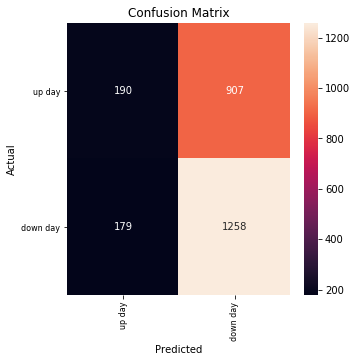

In [566]:
import seaborn as sns
cm = confusion_matrix(actual, [1 if p > 0 else 0 for p in predicted])
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, ax = ax, fmt='g')

ax.set_title('Confusion Matrix') 
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

ax.xaxis.set_ticklabels(['up day','down day'])
ax.yaxis.set_ticklabels(['up day','down day'])
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 8)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 8)  
plt.show()

# Prediksi Market LPKR

In [605]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import io, base64, os, json, re 
import pandas as pd
import numpy as np
import datetime
from random import randint

In [606]:
lpkr_df = pd.read_csv('C:\proyek_prob\LPKR.JK.csv')
lpkr_df['Date'] = pd.to_datetime(lpkr_df['Date'])

cut_off_date = '2010-01-01' 
lpkr_df = lpkr_df[lpkr_df['Date'] >= cut_off_date]


lpkr_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-12-06,211.089005,215.850006,211.089005,214.263000,214.263000,6069678.0
1,2018-12-07,211.089005,214.263000,207.914993,207.914993,207.914993,150681292.0
2,2018-12-10,206.328003,209.501999,199.979004,204.740005,204.740005,68110765.0
3,2018-12-11,204.740005,206.328003,203.153000,206.328003,206.328003,6429193.0
4,2018-12-12,206.328003,207.914993,204.740005,207.914993,207.914993,7540000.0


In [607]:
new_set = []
for row_set in range(0, 10000):
    if row_set%2000==0: print(row_set)
    row_quant = randint(10, 30)
    row_start = randint(0, len(asri_df)-row_quant)
    market_subset = asri_df.iloc[row_start:row_start+row_quant]

    Close_Date = max(market_subset['Date'])
    if row_set%2000==0: print(Close_Date)
    
    # Close_Gap = (market_subset['Close'] - market_subset['Close'].shift(1)) / market_subset['Close'].shift(1)
    Close_Gap = market_subset['Close'].pct_change()
    High_Gap = market_subset['High'].pct_change()
    Low_Gap = market_subset['Low'].pct_change() 
    Volume_Gap = market_subset['Volume'].pct_change() 
    Daily_Change = (market_subset['Close'] - market_subset['Open']) / market_subset['Open']
    Outcome_Next_Day_Direction = (market_subset['Volume'].shift(-1) - market_subset['Volume'])
    
    new_set.append(pd.DataFrame({'Sequence_ID':[row_set]*len(market_subset),
                            'Close_Date':[Close_Date]*len(market_subset),
                           'Close_Gap':Close_Gap,
                           'High_Gap':High_Gap,
                           'Low_Gap':Low_Gap,
                           'Volume_Gap':Volume_Gap,
                           'Daily_Change':Daily_Change,
                           'Outcome_Next_Day_Direction':Outcome_Next_Day_Direction}))

0
2019-10-04 00:00:00
2000
2019-07-02 00:00:00
4000
2019-10-30 00:00:00
6000
2019-04-24 00:00:00
8000
2019-03-07 00:00:00


In [608]:
len(market_subset)

10

In [609]:
new_set_df = pd.concat(new_set)
print(new_set_df.shape)
new_set_df = new_set_df.dropna(how='any') 
print(new_set_df.shape)
new_set_df.tail(20)

(198987, 8)
(172913, 8)


,Sequence_ID,Close_Date,Close_Gap,High_Gap,Low_Gap,Volume_Gap,Daily_Change,Outcome_Next_Day_Direction
219,9998,2019-10-25,-0.014493,0.007194,-0.007299,0.842536,-0.028571,-7232600.0
220,9998,2019-10-25,0.014706,-0.014286,0.000000,-0.610712,0.007299,1057500.0
221,9998,2019-10-25,0.000000,0.014493,0.014706,0.229378,-0.007194,1472100.0
222,9998,2019-10-25,0.000000,0.007143,-0.007246,0.259730,-0.014286,-1609100.0
223,9998,2019-10-25,0.000000,-0.007092,0.000000,-0.225367,-0.014286,3925700.0
224,9998,2019-10-25,0.028986,0.028571,0.014599,0.709789,0.021583,-3839600.0
225,9998,2019-10-25,0.021127,0.013889,0.021583,-0.406028,0.013986,-3760600.0
226,9998,2019-10-25,-0.013793,-0.006849,0.000000,-0.669515,-0.013793,598000.0
227,9998,2019-10-25,-0.006993,0.000000,0.000000,0.322146,-0.006993,-12100.0
228,9998,2019-10-25,0.007042,-0.006897,-0.007042,-0.004930,0.007042,134000.0


In [610]:
new_set_df.head()

,Sequence_ID,Close_Date,Close_Gap,High_Gap,Low_Gap,Volume_Gap,Daily_Change,Outcome_Next_Day_Direction
195,0,2019-10-04,0.006536,0.000000,0.006536,0.126795,0.000000,2855900.0
196,0,2019-10-04,-0.006494,0.000000,-0.006494,0.665494,-0.006494,-1604400.0
197,0,2019-10-04,0.026144,0.006410,0.000000,-0.224476,0.026144,-75000.0
198,0,2019-10-04,-0.019108,0.012739,0.006536,-0.013531,-0.019108,6221800.0
199,0,2019-10-04,0.045455,0.012579,0.000000,1.137877,0.045455,-4682500.0


In [611]:
# Close_Gap
new_set_df['Close_Gap_LMH'] = pd.qcut(new_set_df['Close_Gap'], 3, labels=["L", "M", "H"])

# High_Gap - not used in this example
new_set_df['High_Gap_LMH'] = pd.qcut(new_set_df['High_Gap'], 3, labels=["L", "M", "H"])

# Low_Gap - not used in this example
new_set_df['Low_Gap_LMH'] = pd.qcut(new_set_df['Low_Gap'], 3, labels=["L", "M", "H"])

# Volume_Gap
new_set_df['Volume_Gap_LMH'] = pd.qcut(new_set_df['Volume_Gap'], 3, labels=["L", "M", "H"])
 
# Daily_Change
new_set_df['Daily_Change_LMH'] = pd.qcut(new_set_df['Daily_Change'], 3, labels=["L", "M", "H"])

# new set
new_set_df = new_set_df[["Sequence_ID", 
                         "Close_Date", 
                         "Close_Gap_LMH", 
                         "Volume_Gap_LMH", 
                         "Daily_Change_LMH", 
                         "Outcome_Next_Day_Direction"]]

new_set_df['Event_Pattern'] = new_set_df['Close_Gap_LMH'].astype(str) + new_set_df['Volume_Gap_LMH'].astype(str) + new_set_df['Daily_Change_LMH'].astype(str)

In [612]:
new_set_df.tail(10)

,Sequence_ID,Close_Date,Close_Gap_LMH,Volume_Gap_LMH,Daily_Change_LMH,Outcome_Next_Day_Direction,Event_Pattern
229,9998,2019-10-25,M,M,M,6009400.0,MMM
230,9998,2019-10-25,H,H,H,-4143100.0,HHH
238,9999,2019-11-15,H,M,H,235100.0,HMH
239,9999,2019-11-15,L,M,L,-1299200.0,LML
240,9999,2019-11-15,L,L,M,372500.0,LLM
241,9999,2019-11-15,M,M,M,1821900.0,MMM
242,9999,2019-11-15,H,H,H,-1494100.0,HHH
243,9999,2019-11-15,L,M,L,148800.0,LML
244,9999,2019-11-15,M,M,M,4788000.0,MMM
245,9999,2019-11-15,L,H,L,-4857300.0,LHL


In [613]:
new_set_df['Outcome_Next_Day_Direction'].describe()

count    1.729130e+05
mean    -6.011953e+04
std      8.712031e+06
min     -4.251000e+07
25%     -3.760600e+06
50%      1.997000e+05
75%      3.125600e+06
max      4.333470e+07
Name: Outcome_Next_Day_Direction, dtype: float64

In [614]:
compressed_set = new_set_df.groupby(['Sequence_ID','Close_Date'])['Event_Pattern'].apply(lambda x: "{%s}" % ', '.join(x)).reset_index()

print(compressed_set.shape)
compressed_set.head() 

(10000, 3)


,Sequence_ID,Close_Date,Event_Pattern
0,0,2019-10-04,"{HMM, LHM, HMH, LML, HHH, LLL, LML, MLL, LMM, ..."
1,1,2019-02-05,"{HMM, MMM, HHH, HMM, MLH, LLL, HHH, HLM, LLL, ..."
2,2,2019-05-22,"{LML, MLM, MMM, MLM, HHH, LHL, LLL, HMH, LMM, ..."
3,3,2019-11-06,"{MML, MML, HHH, HLH, LLL, LMM, HMH, MMM, HHH, ..."
4,4,2019-04-23,"{HLH, MHM, HLM, LHL, HHH, HMH, MLM, HHH, HLL, ..."


In [615]:
compressed_outcomes = new_set_df.groupby(['Sequence_ID', 'Close_Date'])['Outcome_Next_Day_Direction'].mean()
compressed_outcomes = compressed_outcomes.to_frame().reset_index()
print(compressed_outcomes.shape)
compressed_outcomes.describe()

(10000, 3)


,Sequence_ID,Outcome_Next_Day_Direction
count,10000.00000,1.000000e+04
mean,4999.50000,-6.283638e+04
std,2886.89568,7.014643e+05
min,0.00000,-7.264825e+06
25%,2499.75000,-3.133680e+05
50%,4999.50000,-1.682513e+04
75%,7499.25000,2.038077e+05
max,9999.00000,7.009862e+06


In [616]:
compressed_set = pd.merge(compressed_set, compressed_outcomes, on= ['Sequence_ID', 'Close_Date'], how='inner')
print(compressed_set.shape)
compressed_set.head()

(10000, 4)


,Sequence_ID,Close_Date,Event_Pattern,Outcome_Next_Day_Direction
0,0,2019-10-04,"{HMM, LHM, HMH, LML, HHH, LLL, LML, MLL, LMM, ...",25985.714286
1,1,2019-02-05,"{HMM, MMM, HHH, HMM, MLH, LLL, HHH, HLM, LLL, ...",-590466.666667
2,2,2019-05-22,"{LML, MLM, MMM, MLM, HHH, LHL, LLL, HMH, LMM, ...",-257577.777778
3,3,2019-11-06,"{MML, MML, HHH, HLH, LLL, LMM, HMH, MMM, HHH, ...",-167358.823529
4,4,2019-04-23,"{HLH, MHM, HLM, LHL, HHH, HMH, MLM, HHH, HLL, ...",661265.000000


In [617]:
compressed_set['Event_Pattern'] = [''.join(e.split()).replace('{','').replace('}','') for e in compressed_set['Event_Pattern'].values]
compressed_set.head()

,Sequence_ID,Close_Date,Event_Pattern,Outcome_Next_Day_Direction
0,0,2019-10-04,"HMM,LHM,HMH,LML,HHH,LLL,LML,MLL,LMM,HMH,MML,LM...",25985.714286
1,1,2019-02-05,"HMM,MMM,HHH,HMM,MLH,LLL,HHH,HLM,LLL,LLM,HMH,MM...",-590466.666667
2,2,2019-05-22,"LML,MLM,MMM,MLM,HHH,LHL,LLL,HMH,LMM,LHL,MLM,LH...",-257577.777778
3,3,2019-11-06,"MML,MML,HHH,HLH,LLL,LMM,HMH,MMM,HHH,LLM,LLL,MH...",-167358.823529
4,4,2019-04-23,"HLH,MHM,HLM,LHL,HHH,HMH,MLM,HHH,HLL,HMH,HHH,LL...",661265.000000


In [618]:
compressed_set_validation = compressed_set[compressed_set['Close_Date'] >= datetime.datetime.now() - datetime.timedelta(days=90)] # Sys.Date()-90 

compressed_set_validation.shape

(2637, 4)

In [619]:
compressed_set = compressed_set[compressed_set['Close_Date'] < datetime.datetime.now() - datetime.timedelta(days=90)]  
compressed_set.shape

(7363, 4)

In [620]:
list(compressed_set)

['Sequence_ID', 'Close_Date', 'Event_Pattern', 'Outcome_Next_Day_Direction']

In [621]:
compressed_set = compressed_set[['Sequence_ID', 'Event_Pattern','Outcome_Next_Day_Direction']]
compressed_set_validation = compressed_set_validation[['Sequence_ID', 'Event_Pattern','Outcome_Next_Day_Direction']]

In [622]:
compressed_set['Outcome_Next_Day_Direction'].describe()

count    7.363000e+03
mean    -9.622006e+04
std      7.931636e+05
min     -7.264825e+06
25%     -4.057043e+05
50%     -4.338824e+04
75%      2.174936e+05
max      7.009862e+06
Name: Outcome_Next_Day_Direction, dtype: float64

In [623]:
print(len(compressed_set['Outcome_Next_Day_Direction']))
len(compressed_set[abs(compressed_set['Outcome_Next_Day_Direction']) > 100000])

7363


6036

In [624]:
print('all moves:', len(compressed_set))
compressed_set = compressed_set[abs(compressed_set['Outcome_Next_Day_Direction']) > 100000]
compressed_set['Outcome_Next_Day_Direction'] = np.where((compressed_set['Outcome_Next_Day_Direction'] > 0), 1, 0)
compressed_set_validation['Outcome_Next_Day_Direction'] = np.where((compressed_set_validation['Outcome_Next_Day_Direction'] > 0), 1, 0)
print('big moves only:', len(compressed_set))

all moves: 7363
big moves only: 6036


In [625]:
compressed_set.head()

,Sequence_ID,Event_Pattern,Outcome_Next_Day_Direction
1,1,"HMM,MMM,HHH,HMM,MLH,LLL,HHH,HLM,LLL,LLM,HMH,MM...",0
2,2,"LML,MLM,MMM,MLM,HHH,LHL,LLL,HMH,LMM,LHL,MLM,LH...",0
4,4,"HLH,MHM,HLM,LHL,HHH,HMH,MLM,HHH,HLL,HMH,HHH,LL...",1
8,8,"MLM,HLH,HHH,LHL,HLH,MLM,HHH,MLM,HHH,MLM,MMM,HH...",0
12,12,"MMM,MHH,LML,LLL,MMM,MHM,LML,LLL,LHL,MMH,MMM,HM...",1


In [626]:
compressed_set_pos = compressed_set[compressed_set['Outcome_Next_Day_Direction']==1][['Sequence_ID', 'Event_Pattern']]
print(compressed_set_pos.shape)
compressed_set_neg = compressed_set[compressed_set['Outcome_Next_Day_Direction']==0][['Sequence_ID', 'Event_Pattern']]
print(compressed_set_neg.shape)

(2624, 2)
(3412, 2)


In [627]:
flat_list = [item.split(',') for item in compressed_set['Event_Pattern'].values ]
unique_patterns = ','.join(str(r) for v in flat_list for r in v)
unique_patterns = list(set(unique_patterns.split(',')))
len(unique_patterns)

22

In [628]:
compressed_set['Outcome_Next_Day_Direction'].head() 

1     0
2     0
4     1
8     0
12    1
Name: Outcome_Next_Day_Direction, dtype: int32

## Markov transition grid 

In [629]:
# build the markov transition grid
def build_transition_grid(compressed_grid, unique_patterns):
    # build the markov transition grid

    patterns = []
    counts = []
    for from_event in unique_patterns:

        # how many times 
        for to_event in unique_patterns:
            pattern = from_event + ',' + to_event # MMM,MlM

            ids_matches = compressed_grid[compressed_grid['Event_Pattern'].str.contains(pattern)]
            found = 0
            if len(ids_matches) > 0:
                Event_Pattern = '---'.join(ids_matches['Event_Pattern'].values)
                found = Event_Pattern.count(pattern)
            patterns.append(pattern)
            counts.append(found)

    # create to/from grid
    grid_Df = pd.DataFrame({'pairs':patterns, 'counts': counts})

    grid_Df['x'], grid_Df['y'] = grid_Df['pairs'].str.split(',', 1).str
    grid_Df.head()

    grid_Df = grid_Df.pivot(index='x', columns='y', values='counts')

    grid_Df.columns= [col for col in grid_Df.columns]
    del grid_Df.index.name

    # replace all NaN with zeros
    grid_Df.fillna(0, inplace=True)
    grid_Df.head()

    #grid_Df.rowSums(transition_dataframe) 
    grid_Df = grid_Df / grid_Df.sum(1)
    return (grid_Df)

In [630]:
grid_pos = build_transition_grid(compressed_set_pos, unique_patterns) 
grid_neg = build_transition_grid(compressed_set_neg, unique_patterns)

In [631]:
grid_neg.head()

,HHH,HHM,HLH,HLL,HLM,HMH,HMM,LHL,LHM,LLL,...,LML,LMM,MHH,MHL,MHM,MLH,MLL,MLM,MMH,MMM
HHH,0.149336,0.0,0.0,0.939252,0.559536,0.326983,0.482609,0.189881,0.000000,0.276843,...,0.099634,0.0,0.0,0.0,0.000000,0.0,0.0,0.211304,0.512605,0.006812
HHM,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.087093,0.0,0.0,0.000000,0.000000,0.000000
HLH,0.141704,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.008338,0.088398,0.083978,...,0.092304,0.0,0.0,0.0,0.075957,0.0,0.0,0.069946,0.000000,0.000000
HLL,0.000000,0.0,0.0,0.000000,0.000000,0.044798,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
HLM,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.039037,0.000000,0.035678,...,0.074439,0.0,0.0,0.0,0.058824,0.0,0.0,0.000000,0.000000,0.000000


In [632]:
grid_pos.head()

,HHH,HHM,HLH,HLL,HLM,HMH,HMM,LHL,LHM,LLL,...,LML,LMM,MHH,MHL,MHM,MLH,MLL,MLM,MMH,MMM
HHH,0.164015,0.0,0.0,1.047222,0.430887,0.278290,0.313725,0.094048,0.000000,0.326546,...,0.054165,0.0,0.0,0.0,0.000000,0.0,0.0,0.127286,0.303704,0.016593
HHM,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.094640,0.0,0.0,0.000000,0.000000,0.000000
HLH,0.111908,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.097917,0.374177,0.036082,...,0.084676,0.0,0.0,0.0,0.123845,0.0,0.0,0.012634,0.000000,0.000000
HLL,0.000000,0.0,0.0,0.000000,0.000000,0.100587,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
HLM,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.116071,0.000000,0.060825,...,0.100788,0.0,0.0,0.0,0.093161,0.0,0.0,0.000000,0.000000,0.000000


In [633]:
def safe_log(x,y):
   try:
      lg = np.log(x/y)
   except:
      lg = 0
   return lg

# predict on out of sample data
actual = []
predicted = []
for seq_id in compressed_set_validation['Sequence_ID'].values:
    patterns = compressed_set_validation[compressed_set_validation['Sequence_ID'] == seq_id]['Event_Pattern'].values[0].split(',')
    pos = []
    neg = []
    log_odds = []
    
    for id in range(0, len(patterns)-1):
        # get log odds
        # logOdds = log(tp(i,j) / tn(i,j)
        if (patterns[id] in list(grid_pos) and patterns[id+1] in list(grid_pos) and patterns[id] in list(grid_neg) and patterns[id+1] in list(grid_neg)):
                
            numerator = grid_pos[patterns[id]][patterns[id+1]]
            denominator = grid_neg[patterns[id]][patterns[id+1]]
            if (numerator == 0 and denominator == 0):
                log_value =0
            elif (denominator == 0):
                log_value = np.log(numerator / 0.00001)
            elif (numerator == 0):
                log_value = np.log(0.00001 / denominator)
            else:
                log_value = np.log(numerator/denominator)
        else:
            log_value = 0
        
        log_odds.append(log_value)
        
        pos.append(numerator)
        neg.append(denominator)
      
    print('outcome:', compressed_set_validation[compressed_set_validation['Sequence_ID']==seq_id]['Outcome_Next_Day_Direction'].values[0])
    print(sum(pos)/sum(neg))
    print(sum(log_odds))

    actual.append(compressed_set_validation[compressed_set_validation['Sequence_ID']==seq_id]['Outcome_Next_Day_Direction'].values[0])
    predicted.append(sum(log_odds))

from sklearn.metrics import confusion_matrix

confusion_matrix(actual, [1 if p > 0 else 0 for p in predicted])

outcome: 1
0.8819528742605156
2.163158216878425
outcome: 0
0.7230486101089207
-1.0167329795269127
outcome: 1
0.8424378999456614
4.220508305623435
outcome: 1
0.8432388077384126
4.4226568497624985
outcome: 0
0.790392908571111
2.425687278326476
outcome: 1
0.872615059552716
-0.2502764073895601
outcome: 1
0.8090204095640118
1.0774693428826083
outcome: 0
0.7883125947480152
-0.11392372309520482
outcome: 1
0.8882583122921027
6.938451471119795
outcome: 1
0.8507188006316692
4.305217185810806
outcome: 0
1.1323292170539483
6.420400637975046
outcome: 0
0.8696939171205915
2.796086313235723
outcome: 0
1.0134815813977087
3.5103906016441195
outcome: 1
0.8801290370643065
4.045340561723377
outcome: 0
0.7866011916589235
1.6763444288937592
outcome: 1
0.993491841501741
6.300606709827498
outcome: 0
0.8044117890777487
1.4465519177686164
outcome: 1
0.8993332973831897
4.557644628127442
outcome: 0
0.8300872375434812
3.034746067962086
outcome: 1
0.7855280768553992
1.878492973032823
outcome: 1
0.9775011035471237
5

array([[ 193, 1009],
       [ 190, 1245]], dtype=int64)

In [634]:
from sklearn.metrics import accuracy_score
score = accuracy_score(actual, [1 if p > 0 else 0 for p in predicted])
print('Accuracy:', round(score * 100,2), '%')

Accuracy: 54.53 %


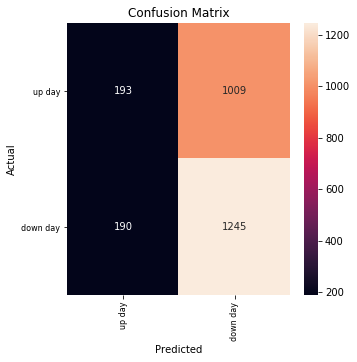

In [635]:
import seaborn as sns
cm = confusion_matrix(actual, [1 if p > 0 else 0 for p in predicted])
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, ax = ax, fmt='g')

ax.set_title('Confusion Matrix') 
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

ax.xaxis.set_ticklabels(['up day','down day'])
ax.yaxis.set_ticklabels(['up day','down day'])
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 8)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 8)  
plt.show()

# Prediksi Market BSDE

In [636]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import io, base64, os, json, re 
import pandas as pd
import numpy as np
import datetime
from random import randint

In [637]:
bsde_df = pd.read_csv("C:\proyek_prob\BSDE.JK.csv")
bsde_df['Date'] = pd.to_datetime(bsde_df['Date'])

cut_off_date = '2019-01-01' 
bsde_df = bsde_df[bsde_df['Date'] >= cut_off_date]


bsde_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
18,2019-01-01,1255.0,1255.0,1255.0,1255.0,1255.0,0.0
19,2019-01-02,1255.0,1270.0,1245.0,1255.0,1255.0,5913400.0
20,2019-01-03,1260.0,1320.0,1255.0,1320.0,1320.0,15494300.0
21,2019-01-04,1310.0,1355.0,1305.0,1355.0,1355.0,16848600.0
22,2019-01-07,1380.0,1410.0,1380.0,1405.0,1405.0,37577400.0


In [638]:
new_set = []
for row_set in range(0, 10000):
    if row_set%2000==0: print(row_set)
    row_quant = randint(10, 30)
    row_start = randint(0, len(asri_df)-row_quant)
    market_subset = asri_df.iloc[row_start:row_start+row_quant]

    Close_Date = max(market_subset['Date'])
    if row_set%2000==0: print(Close_Date)
    
    # Close_Gap = (market_subset['Close'] - market_subset['Close'].shift(1)) / market_subset['Close'].shift(1)
    Close_Gap = market_subset['Close'].pct_change()
    High_Gap = market_subset['High'].pct_change()
    Low_Gap = market_subset['Low'].pct_change() 
    Volume_Gap = market_subset['Volume'].pct_change() 
    Daily_Change = (market_subset['Close'] - market_subset['Open']) / market_subset['Open']
    Outcome_Next_Day_Direction = (market_subset['Volume'].shift(-1) - market_subset['Volume'])
    
    new_set.append(pd.DataFrame({'Sequence_ID':[row_set]*len(market_subset),
                            'Close_Date':[Close_Date]*len(market_subset),
                           'Close_Gap':Close_Gap,
                           'High_Gap':High_Gap,
                           'Low_Gap':Low_Gap,
                           'Volume_Gap':Volume_Gap,
                           'Daily_Change':Daily_Change,
                           'Outcome_Next_Day_Direction':Outcome_Next_Day_Direction}))

0
2019-05-30 00:00:00
2000
2019-06-20 00:00:00
4000
2019-03-06 00:00:00
6000
2019-02-28 00:00:00
8000
2019-08-13 00:00:00


In [639]:
len(market_subset)

11

In [640]:
new_set_df = pd.concat(new_set)
print(new_set_df.shape)
new_set_df = new_set_df.dropna(how='any') 
print(new_set_df.shape)
new_set_df.tail(20)

(199876, 8)
(173824, 8)


,Sequence_ID,Close_Date,Close_Gap,High_Gap,Low_Gap,Volume_Gap,Daily_Change,Outcome_Next_Day_Direction
38,9998,2019-02-13,0.005650,-0.037234,0.000000,-0.592925,0.005650,5843100.0
39,9998,2019-02-13,0.005618,-0.005525,-0.028571,0.466433,0.005618,3125600.0
40,9998,2019-02-13,-0.005587,0.016667,0.041176,0.170144,-0.005587,-13443300.0
41,9998,2019-02-13,0.000000,-0.010929,0.005650,-0.625389,-0.005587,3635500.0
42,9998,2019-02-13,-0.016854,-0.005525,-0.028090,0.451469,-0.027778,-11688100.0
43,9998,2019-02-13,0.000000,-0.027778,0.011561,-1.000000,0.000000,20538100.0
44,9998,2019-02-13,0.045714,0.045714,-0.005714,inf,0.016667,6990400.0
45,9998,2019-02-13,0.010929,0.027322,0.045977,0.340363,0.016484,-14658600.0
46,9998,2019-02-13,-0.027027,-0.010638,-0.027473,-0.532488,-0.016393,-1814500.0
47,9998,2019-02-13,-0.022222,-0.021505,-0.011299,-0.140988,-0.022222,12643400.0


In [641]:
new_set_df.head()

,Sequence_ID,Close_Date,Close_Gap,High_Gap,Low_Gap,Volume_Gap,Daily_Change,Outcome_Next_Day_Direction
98,0,2019-05-30,0.011494,-0.016667,0.005780,0.217239,0.005714,-8585700.0
99,0,2019-05-30,-0.017045,-0.005650,-0.005747,-0.556544,-0.017045,2722800.0
100,0,2019-05-30,-0.011561,0.000000,-0.017341,0.398006,-0.017241,2107800.0
101,0,2019-05-30,-0.017544,-0.028409,-0.047059,0.220391,-0.017544,-5549200.0
102,0,2019-05-30,0.000000,0.005848,0.018519,-0.475441,0.000000,1076800.0


In [642]:
# Close Gap
new_set_df['Close_Gap_LMH'] = pd.qcut(new_set_df['Close_Gap'], 3, labels=["L", "M", "H"])

# High Gap
new_set_df['High_Gap_LMH'] = pd.qcut(new_set_df['High_Gap'], 3, labels=["L", "M", "H"])

# Low Gap
new_set_df['Low_Gap_LMH'] = pd.qcut(new_set_df['Low_Gap'], 3, labels=["L", "M", "H"])

# Volume Gap
new_set_df['Volume_Gap_LMH'] = pd.qcut(new_set_df['Volume_Gap'], 3, labels=["L", "M", "H"])
 
# Daily Change
new_set_df['Daily_Change_LMH'] = pd.qcut(new_set_df['Daily_Change'], 3, labels=["L", "M", "H"])

# new set
new_set_df = new_set_df[["Sequence_ID", 
                         "Close_Date", 
                         "Close_Gap_LMH", 
                         "Volume_Gap_LMH", 
                         "Daily_Change_LMH", 
                         "Outcome_Next_Day_Direction"]]

new_set_df['Event_Pattern'] = new_set_df['Close_Gap_LMH'].astype(str) + new_set_df['Volume_Gap_LMH'].astype(str) + new_set_df['Daily_Change_LMH'].astype(str)

In [643]:
new_set_df.tail(10)

,Sequence_ID,Close_Date,Close_Gap_LMH,Volume_Gap_LMH,Daily_Change_LMH,Outcome_Next_Day_Direction,Event_Pattern
48,9998,2019-02-13,L,H,L,-18439700.0,LHL
171,9999,2019-08-15,L,L,L,6807800.0,LLL
172,9999,2019-08-15,L,H,L,-3407500.0,LHL
173,9999,2019-08-15,M,M,H,2002200.0,MMH
174,9999,2019-08-15,M,M,M,-1563600.0,MMM
175,9999,2019-08-15,H,M,H,-2346200.0,HMH
176,9999,2019-08-15,L,M,L,-5505800.0,LML
177,9999,2019-08-15,H,L,M,5359800.0,HLM
178,9999,2019-08-15,M,H,M,-1270400.0,MHM
179,9999,2019-08-15,H,M,H,-1292600.0,HMH


In [644]:
new_set_df['Outcome_Next_Day_Direction'].describe()

count    1.738240e+05
mean    -7.666303e+04
std      8.773535e+06
min     -4.251000e+07
25%     -3.780350e+06
50%      1.997000e+05
75%      3.125600e+06
max      4.333470e+07
Name: Outcome_Next_Day_Direction, dtype: float64

In [645]:
compressed_set = new_set_df.groupby(['Sequence_ID','Close_Date'])['Event_Pattern'].apply(lambda x: "{%s}" % ', '.join(x)).reset_index()

print(compressed_set.shape)
compressed_set.head()

(10000, 3)


,Sequence_ID,Close_Date,Event_Pattern
0,0,2019-05-30,"{HMH, LLL, LHL, LML, MLM, MMM, MLM, HHH, LHL, ..."
1,1,2019-07-17,"{HHH, MLM, MMM, HHH, LLL, LLL, HHH, HHH, LML, ..."
2,2,2019-07-25,"{HHH, HHH, LLL, MHH, MLL, MHM, HHH, LLL, MHM, ..."
3,3,2019-05-15,"{HHH, MLM, LHM, HMH, LLL, LHL, LML, MLM, MMM, ..."
4,4,2019-09-16,"{MHL, LHL, HLH, LHL, HLH, LHM, MLM, LHL, HMM, ..."


In [646]:
compressed_outcomes = new_set_df.groupby(['Sequence_ID', 'Close_Date'])['Outcome_Next_Day_Direction'].mean()
compressed_outcomes = compressed_outcomes.to_frame().reset_index()
print(compressed_outcomes.shape)
compressed_outcomes.describe()

(10000, 3)


,Sequence_ID,Outcome_Next_Day_Direction
count,10000.00000,1.000000e+04
mean,4999.50000,-8.381043e+04
std,2886.89568,6.688741e+05
min,0.00000,-7.264825e+06
25%,2499.75000,-3.394721e+05
50%,4999.50000,-3.022308e+04
75%,7499.25000,1.919177e+05
max,9999.00000,7.009862e+06


In [647]:
compressed_set = pd.merge(compressed_set, compressed_outcomes, on= ['Sequence_ID', 'Close_Date'], how='inner')
print(compressed_set.shape)
compressed_set.head()

(10000, 4)


,Sequence_ID,Close_Date,Event_Pattern,Outcome_Next_Day_Direction
0,0,2019-05-30,"{HMH, LLL, LHL, LML, MLM, MMM, MLM, HHH, LHL, ...",-5.713630e+05
1,1,2019-07-17,"{HHH, MLM, MMM, HHH, LLL, LLL, HHH, HHH, LML, ...",-1.875370e+05
2,2,2019-07-25,"{HHH, HHH, LLL, MHH, MLL, MHM, HHH, LLL, MHM, ...",-2.738909e+05
3,3,2019-05-15,"{HHH, MLM, LHM, HMH, LLL, LHL, LML, MLM, MMM, ...",-1.165405e+06
4,4,2019-09-16,"{MHL, LHL, HLH, LHL, HLH, LHM, MLM, LHL, HMM, ...",-6.150667e+04


In [648]:
compressed_set['Event_Pattern'] = [''.join(e.split()).replace('{','').replace('}','') for e in compressed_set['Event_Pattern'].values]
compressed_set.head()

,Sequence_ID,Close_Date,Event_Pattern,Outcome_Next_Day_Direction
0,0,2019-05-30,"HMH,LLL,LHL,LML,MLM,MMM,MLM,HHH,LHL,LLL,HMH,LM...",-5.713630e+05
1,1,2019-07-17,"HHH,MLM,MMM,HHH,LLL,LLL,HHH,HHH,LML,MLM,HHH,HH...",-1.875370e+05
2,2,2019-07-25,"HHH,HHH,LLL,MHH,MLL,MHM,HHH,LLL,MHM,MLM,MMM",-2.738909e+05
3,3,2019-05-15,"HHH,MLM,LHM,HMH,LLL,LHL,LML,MLM,MMM,MLM,HHH,LH...",-1.165405e+06
4,4,2019-09-16,"MHL,LHL,HLH,LHL,HLH,LHM,MLM,LHL,HMM,LHM,HMH,LM...",-6.150667e+04


In [649]:
compressed_set_validation = compressed_set[compressed_set['Close_Date'] >= datetime.datetime.now() - datetime.timedelta(days=90)] # Sys.Date()-90 

compressed_set_validation.shape

(2597, 4)

In [650]:
compressed_set = compressed_set[compressed_set['Close_Date'] < datetime.datetime.now() - datetime.timedelta(days=90)]  
compressed_set.shape

(7403, 4)

In [651]:
list(compressed_set)

['Sequence_ID', 'Close_Date', 'Event_Pattern', 'Outcome_Next_Day_Direction']

In [652]:
compressed_set = compressed_set[['Sequence_ID', 'Event_Pattern','Outcome_Next_Day_Direction']]
compressed_set_validation = compressed_set_validation[['Sequence_ID', 'Event_Pattern','Outcome_Next_Day_Direction']]

In [653]:
compressed_set['Outcome_Next_Day_Direction'].describe()

count    7.403000e+03
mean    -1.205549e+05
std      7.533632e+05
min     -7.264825e+06
25%     -4.256947e+05
50%     -5.856000e+04
75%      2.042833e+05
max      7.009862e+06
Name: Outcome_Next_Day_Direction, dtype: float64

In [654]:
print(len(compressed_set['Outcome_Next_Day_Direction']))
len(compressed_set[abs(compressed_set['Outcome_Next_Day_Direction']) > 100000])

7403


6090

In [655]:
# keep only keep big/interesting moves 
print('all moves:', len(compressed_set))
compressed_set = compressed_set[abs(compressed_set['Outcome_Next_Day_Direction']) > 100000]
compressed_set['Outcome_Next_Day_Direction'] = np.where((compressed_set['Outcome_Next_Day_Direction'] > 0), 1, 0)
compressed_set_validation['Outcome_Next_Day_Direction'] = np.where((compressed_set_validation['Outcome_Next_Day_Direction'] > 0), 1, 0)
print('big moves only:', len(compressed_set))

all moves: 7403
big moves only: 6090


In [656]:
compressed_set.head()

,Sequence_ID,Event_Pattern,Outcome_Next_Day_Direction
0,0,"HMH,LLL,LHL,LML,MLM,MMM,MLM,HHH,LHL,LLL,HMH,LM...",0
1,1,"HHH,MLM,MMM,HHH,LLL,LLL,HHH,HHH,LML,MLM,HHH,HH...",0
2,2,"HHH,HHH,LLL,MHH,MLL,MHM,HHH,LLL,MHM,MLM,MMM",0
3,3,"HHH,MLM,LHM,HMH,LLL,LHL,LML,MLM,MMM,MLM,HHH,LH...",0
5,5,"MMH,MLM,HHH,MLM,LHM,HMH,LLL,LHL,LML,MLM,MMM,ML...",1


In [657]:
# create two data sets - won/not won
compressed_set_pos = compressed_set[compressed_set['Outcome_Next_Day_Direction']==1][['Sequence_ID', 'Event_Pattern']]
print(compressed_set_pos.shape)
compressed_set_neg = compressed_set[compressed_set['Outcome_Next_Day_Direction']==0][['Sequence_ID', 'Event_Pattern']]
print(compressed_set_neg.shape)

(2594, 2)
(3496, 2)


In [658]:
flat_list = [item.split(',') for item in compressed_set['Event_Pattern'].values ]
unique_patterns = ','.join(str(r) for v in flat_list for r in v)
unique_patterns = list(set(unique_patterns.split(',')))
len(unique_patterns)

22

In [659]:
compressed_set['Outcome_Next_Day_Direction'].head() 

0    0
1    0
2    0
3    0
5    1
Name: Outcome_Next_Day_Direction, dtype: int32

## Markov transition grid 

In [660]:
# build the markov transition grid
def build_transition_grid(compressed_grid, unique_patterns):
    # build the markov transition grid

    patterns = []
    counts = []
    for from_event in unique_patterns:

        # how many times 
        for to_event in unique_patterns:
            pattern = from_event + ',' + to_event # MMM,MlM

            ids_matches = compressed_grid[compressed_grid['Event_Pattern'].str.contains(pattern)]
            found = 0
            if len(ids_matches) > 0:
                Event_Pattern = '---'.join(ids_matches['Event_Pattern'].values)
                found = Event_Pattern.count(pattern)
            patterns.append(pattern)
            counts.append(found)

    # create to/from grid
    grid_Df = pd.DataFrame({'pairs':patterns, 'counts': counts})

    grid_Df['x'], grid_Df['y'] = grid_Df['pairs'].str.split(',', 1).str
    grid_Df.head()

    grid_Df = grid_Df.pivot(index='x', columns='y', values='counts')

    grid_Df.columns= [col for col in grid_Df.columns]
    del grid_Df.index.name

    # replace all NaN with zeros
    grid_Df.fillna(0, inplace=True)
    grid_Df.head()

    #grid_Df.rowSums(transition_dataframe) 
    grid_Df = grid_Df / grid_Df.sum(1)
    return (grid_Df)

In [661]:
grid_pos = build_transition_grid(compressed_set_pos, unique_patterns) 
grid_neg = build_transition_grid(compressed_set_neg, unique_patterns)

In [662]:
grid_neg.head()

,HHH,HHM,HLH,HLL,HLM,HMH,HMM,LHL,LHM,LLL,...,LML,LMM,MHH,MHL,MHM,MLH,MLL,MLM,MMH,MMM
HHH,0.141114,0.0,0.0,0.9375,0.55414,0.333601,0.467391,0.212485,0.000000,0.270507,...,0.099099,0.0,0.0,0.0,0.000000,0.0,0.0,0.214512,0.54067,0.00565
HHM,0.000000,0.0,0.0,0.0000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.082018,0.0,0.0,0.000000,0.00000,0.00000
HLH,0.148456,0.0,0.0,0.0000,0.00000,0.000000,0.000000,0.008804,0.039909,0.091269,...,0.096622,0.0,0.0,0.0,0.072717,0.0,0.0,0.074313,0.00000,0.00000
HLL,0.000000,0.0,0.0,0.0000,0.00000,0.048173,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.00000
HLM,0.000000,0.0,0.0,0.0000,0.00000,0.000000,0.000000,0.043617,0.000000,0.029543,...,0.075901,0.0,0.0,0.0,0.058625,0.0,0.0,0.000000,0.00000,0.00000


In [663]:
grid_pos.head()

,HHH,HHM,HLH,HLL,HLM,HMH,HMM,LHL,LHM,LLL,...,LML,LMM,MHH,MHL,MHM,MLH,MLL,MLM,MMH,MMM
HHH,0.157866,0.0,0.0,1.058824,0.386288,0.272507,0.305128,0.095208,0.000000,0.326646,...,0.052473,0.0,0.0,0.0,0.000000,0.0,0.0,0.119221,0.291502,0.016232
HHM,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.087989,0.0,0.0,0.000000,0.000000,0.000000
HLH,0.117952,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.103405,0.295789,0.035237,...,0.081217,0.0,0.0,0.0,0.123603,0.0,0.0,0.010107,0.000000,0.000000
HLL,0.000000,0.0,0.0,0.000000,0.000000,0.100809,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
HLM,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.126734,0.000000,0.047068,...,0.104612,0.0,0.0,0.0,0.104050,0.0,0.0,0.000000,0.000000,0.000000


In [665]:
def safe_log(x,y):
   try:
      lg = np.log(x/y)
   except:
      lg = 0
   return lg

# predict on out of sample data
actual = []
predicted = []
for seq_id in compressed_set_validation['Sequence_ID'].values:
    patterns = compressed_set_validation[compressed_set_validation['Sequence_ID'] == seq_id]['Event_Pattern'].values[0].split(',')
    pos = []
    neg = []
    log_odds = []
    
    for id in range(0, len(patterns)-1):
        # get log odds
        # logOdds = log(tp(i,j) / tn(i,j)
        if (patterns[id] in list(grid_pos) and patterns[id+1] in list(grid_pos) and patterns[id] in list(grid_neg) and patterns[id+1] in list(grid_neg)):
                
            numerator = grid_pos[patterns[id]][patterns[id+1]]
            denominator = grid_neg[patterns[id]][patterns[id+1]]
            if (numerator == 0 and denominator == 0):
                log_value =0
            elif (denominator == 0):
                log_value = np.log(numerator / 0.00001)
            elif (numerator == 0):
                log_value = np.log(0.00001 / denominator)
            else:
                log_value = np.log(numerator/denominator)
        else:
            log_value = 0
        
        log_odds.append(log_value)
        
        pos.append(numerator)
        neg.append(denominator)
      
    print('outcome:', compressed_set_validation[compressed_set_validation['Sequence_ID']==seq_id]['Outcome_Next_Day_Direction'].values[0])
    print(sum(pos)/sum(neg))
    print(sum(log_odds))

    actual.append(compressed_set_validation[compressed_set_validation['Sequence_ID']==seq_id]['Outcome_Next_Day_Direction'].values[0])
    predicted.append(sum(log_odds))

from sklearn.metrics import confusion_matrix

confusion_matrix(actual, [1 if p > 0 else 0 for p in predicted])

outcome: 1
1.0138652674410569
4.312148775760266
outcome: 0
1.0552733003301904
3.1754591182585132
outcome: 1
0.8415036915656132
3.061667239460787
outcome: 0
1.0620688102300269
3.1280811044873778
outcome: 0
0.7889772206185204
2.1532077067989883
outcome: 1
0.9106231151583037
2.2022912943360518
outcome: 1
0.8576244730425768
0.11793519135163288
outcome: 0
0.7058494277199323
2.351008096362369
outcome: 1
1.0237370160950763
4.766368641545113
outcome: 0
0.8704538259241763
3.3524178289985036
outcome: 0
3.949299396578748
2.947143811985012
outcome: 0
0.8767417422341308
3.201995453206258
outcome: 1
0.923092841181335
2.6634610758113424
outcome: 1
0.9038437752475925
2.6531930593811004
outcome: 1
0.8918808933602319
3.3177746607624368
outcome: 1
1.2495345804684814
2.879909247625872
outcome: 0
0.8548959229051873
2.4900358380537866
outcome: 1
0.8618180966578598
2.278320577482946
outcome: 0
0.8547498751896432
3.1887863350503727
outcome: 1
0.8764656935556774
2.6058150456099654
outcome: 0
1.5918954987874145

array([[ 110, 1087],
       [ 163, 1237]], dtype=int64)

In [666]:
from sklearn.metrics import accuracy_score
score = accuracy_score(actual, [1 if p > 0 else 0 for p in predicted])
print('Accuracy:', round(score * 100,2), '%')

Accuracy: 51.87 %


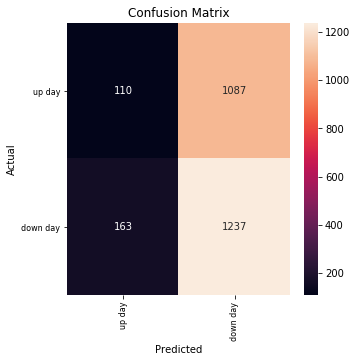

In [667]:
import seaborn as sns
cm = confusion_matrix(actual, [1 if p > 0 else 0 for p in predicted])
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, ax = ax, fmt='g')

ax.set_title('Confusion Matrix') 
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

ax.xaxis.set_ticklabels(['up day','down day'])
ax.yaxis.set_ticklabels(['up day','down day'])
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 8)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 8)  
plt.show()

## Grafik Actual

In [668]:
sns.set(rc={'figure.figsize':(20, 2)})

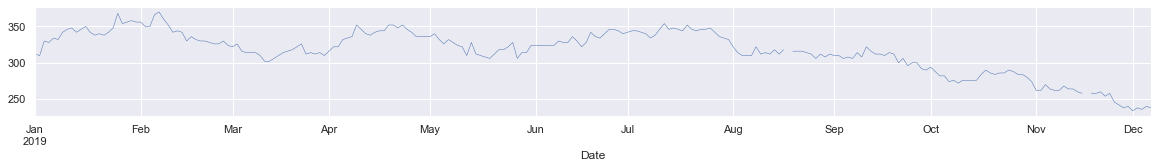

In [673]:
df1 = asri_df.set_index('Date')
sns.set(rc={'figure.figsize':(20, 2)})
df1.loc['2019' : '2020','Close'].plot(linewidth=0.5)

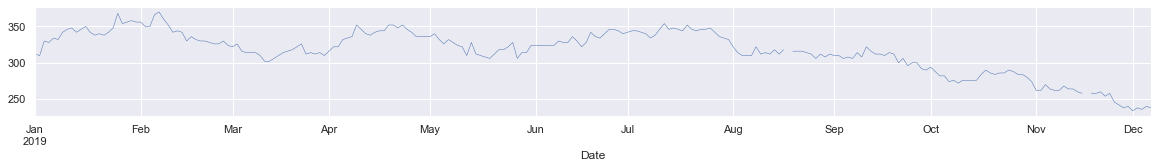

In [670]:
df2 = lpkr_df.set_index('Date')
sns.set(rc={'figure.figsize':(20, 2)})
df1.loc['2019' : '2020','Close'].plot(linewidth=0.5)

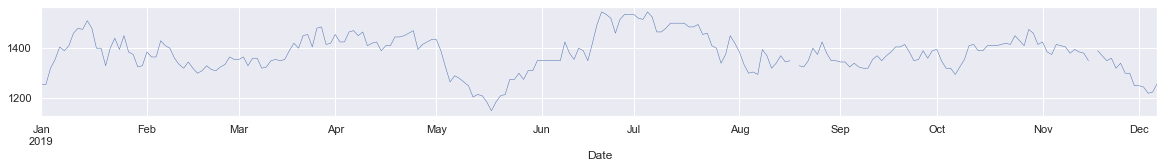

In [674]:
df3 = bsde_df.set_index('Date')
sns.set(rc={'figure.figsize':(20, 2)})
df3.loc['2019' : '2020','Close'].plot(linewidth=0.5)

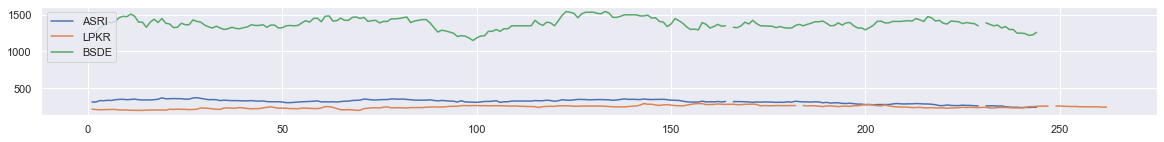

In [675]:
#plot close price day
close_asri = df1['Close']
close_lpkr = df2['Close']
close_bsde = df3['Close']

time_asri = np.linspace(1, len(close_asri), len(close_asri))
time_lpkr = np.linspace(1, len(close_lpkr), len(close_lpkr))
time_bsde = np.linspace(1, len(close_bsde), len(close_bsde))

plt.plot(time_asri, close_asri, label = 'ASRI')
plt.plot(time_lpkr, close_lpkr, label = 'LPKR')
plt.plot(time_bsde, close_bsde, label = 'BSDE')
plt.legend(loc = 'upper left')